In [5]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
import galsim
from pyHalo.preset_models import CDM
from copy import deepcopy
from lenstronomy.Util.correlation import power_spectrum_1d

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):  # ../../
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs, psf

In [6]:
# set directory for all output of this script
save_dir = os.path.join(config.machine.data_dir, 'output', 'power_spectra_dev')
util.create_directory_if_not_exists(save_dir)
util.clear_directory(save_dir)

In [7]:
band = 'F106'
exposure_time = 146
oversample = 5
num_pix = 45
side = 4.95

lens = SampleStrongLens()

z_lens = round(lens.z_lens, 2)
z_source = round(lens.z_source, 2)
# m_host = lens.get_main_halo_mass()
# m_host = lens.lens_mass
# log_m_host = np.log10(m_host)
log_m_host = 13

# set subhalo params
r_tidal = 0.25
sigma_sub = 0.055
subhalo_cone = 6
los_normalization = 0

# nom = CDM(z_lens,
            # z_source,
            # sigma_sub=sigma_sub,
            # log_mlow=6.,
            # log_mhigh=10.,
            # log_m_host=log_m_host,
            # r_tidal=r_tidal,
            # cone_opening_angle_arcsec=subhalo_cone,
            # LOS_normalization=los_normalization)

cut_6 = CDM(z_lens,
            z_source,
            sigma_sub=sigma_sub,
            log_mlow=6.,
            log_mhigh=10.,
            log_m_host=log_m_host,
            r_tidal=r_tidal,
            cone_opening_angle_arcsec=subhalo_cone,
            LOS_normalization=los_normalization)

cut_7 = CDM(z_lens,
            z_source,
            sigma_sub=sigma_sub,
            log_mlow=7.,  # 7
            log_mhigh=10.,
            log_m_host=log_m_host,
            r_tidal=r_tidal,
            cone_opening_angle_arcsec=subhalo_cone,
            LOS_normalization=los_normalization)

cut_8 = CDM(z_lens,
            z_source,
            sigma_sub=sigma_sub,
            log_mlow=8.,  # 8
            log_mhigh=10.,
            log_m_host=log_m_host,
            r_tidal=r_tidal,
            cone_opening_angle_arcsec=subhalo_cone,
            LOS_normalization=los_normalization)

lens_cut_6 = deepcopy(lens)
lens_cut_7 = deepcopy(lens)
lens_cut_8 = deepcopy(lens)

# lens.add_subhalos(nom, suppress_output=True)
lens_cut_6.add_subhalos(cut_6, suppress_output=True)
lens_cut_7.add_subhalos(cut_7, suppress_output=True)
lens_cut_8.add_subhalos(cut_8, suppress_output=True)

lenses = [lens, lens_cut_6, lens_cut_7, lens_cut_8]

# generate models
models = [i.get_array(num_pix=num_pix * oversample, side=side, band=band) for i in lenses]
titles = ['no_subhalos', 'cut_6', 'cut_7', 'cut_8']

# generate images
for sl, model, title in zip(lenses, models, titles):
    # generate subhalo images and save power spectra
    gs_images, _ = gs.get_images(sl, model, band, input_size=num_pix, output_size=num_pix,
                                    grid_oversample=oversample, psf_oversample=oversample,
                                    detector=1, detector_pos=(2048, 2048), suppress_output=True)
    np.save(os.path.join(save_dir, f'image_{title}.npy'), gs_images[0])
    ps, r = power_spectrum_1d(gs_images[0])
    np.save(os.path.join(save_dir, f'ps_{title}.npy'), ps)

np.save(os.path.join(save_dir, 'r.npy'), r)

In [8]:
ps_no_subhalos = np.load(os.path.join(save_dir, 'ps_no_subhalos.npy'))
ps_cut_6 = np.load(os.path.join(save_dir, 'ps_cut_6.npy'))
ps_cut_7 = np.load(os.path.join(save_dir, 'ps_cut_7.npy'))
ps_cut_8 = np.load(os.path.join(save_dir, 'ps_cut_8.npy'))

image_no_subhalos = np.load(os.path.join(save_dir, 'image_no_subhalos.npy'))
image_cut_6 = np.load(os.path.join(save_dir, 'image_cut_6.npy'))
image_cut_7 = np.load(os.path.join(save_dir, 'image_cut_7.npy'))
image_cut_8 = np.load(os.path.join(save_dir, 'image_cut_8.npy'))

In [9]:
dif_6 = ps_cut_6 - ps_no_subhalos
dif_7 = ps_cut_7 - ps_no_subhalos
dif_8 = ps_cut_8 - ps_no_subhalos

res_6 = image_cut_6 - image_no_subhalos
res_7 = image_cut_7 - image_no_subhalos
res_8 = image_cut_8 - image_no_subhalos

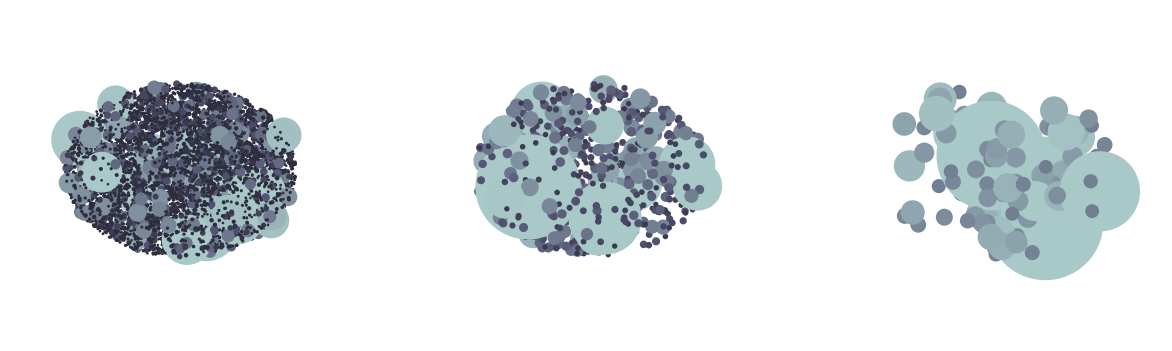

In [10]:
f = plt.figure(figsize=(15, 5))
ax = f.add_subplot(1, 3, 1, projection='3d')
ax.set_axis_off()
ax.set_aspect('equalyz')
cut_6.plot(ax, view_init_1=0., view_init_2=0.)
ax = f.add_subplot(1, 3, 2, projection='3d')
ax.set_axis_off()
ax.set_aspect('equalyz')
cut_7.plot(ax, view_init_1=0., view_init_2=0.)
ax = f.add_subplot(1, 3, 3, projection='3d')
ax.set_axis_off()
ax.set_aspect('equalyz')
cut_8.plot(ax, view_init_1=0., view_init_2=0.)
plt.show()

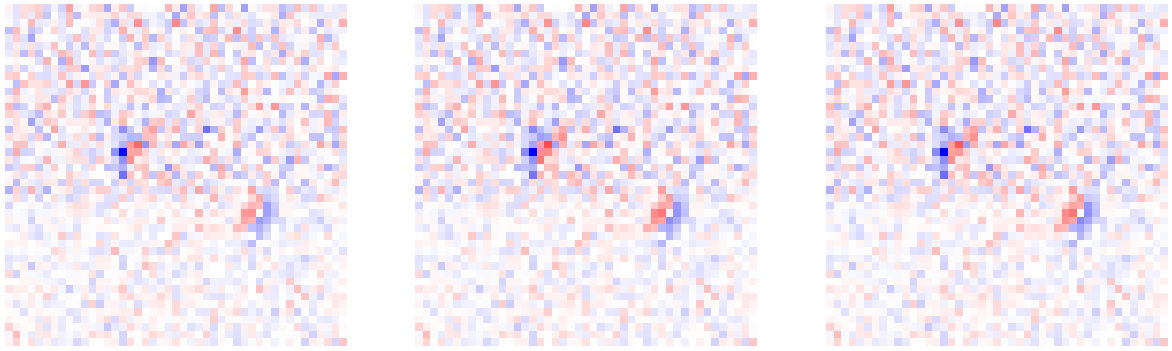

In [13]:
v = plot_util.get_v([res_6, res_7, res_8])

f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(res_6, cmap='bwr', vmin=-v, vmax=v)
# ax[0].set_title('cut_6')
ax[1].imshow(res_7, cmap='bwr', vmin=-v, vmax=v)
# ax[1].set_title('cut_7')
ax[2].imshow(res_8, cmap='bwr', vmin=-v, vmax=v)
# ax[2].set_title('cut_8')
for a in ax:
    a.axis('off')
plt.show()

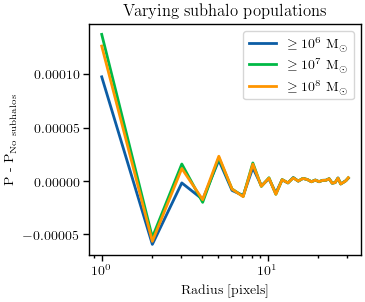

In [14]:
f, ax = plt.subplots(1, 1, figsize=(3.5, 3))
# ax.plot(r, flat_ps, label='flat')
# ax.plot(r, ps_no_subhalos, label='No subhalos')
ax.plot(r, dif_6, label='$\geq 10^6$ M$_\odot$')
ax.plot(r, dif_7, label='$\geq 10^7$ M$_\odot$')
ax.plot(r, dif_8, label='$\geq 10^8$ M$_\odot$')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('Radius [pixels]')
ax.set_ylabel(r'P - P$_{\textrm{No subhalos}}$')
ax.legend()
plt.title('Varying subhalo populations')
plt.savefig(os.path.join(figure_dir, 'ps_subhalo_pop.png'))
plt.show()

In [15]:
band = 'F106'
exposure_time = 146
oversample = 5
num_pix = 45
side = 4.95

lens = SampleStrongLens()

z_lens = round(lens.z_lens, 2)
z_source = round(lens.z_source, 2)
m_host = lens.get_main_halo_mass()
# m_host = lens.lens_mass
log_m_host = np.log10(m_host)

# set subhalo params
r_tidal = 0.25
sigma_sub = 0.055
subhalo_cone = 6
los_normalization = 0

realization = CDM(z_lens,
            z_source,
            sigma_sub=sigma_sub,
            log_mlow=6.,
            log_mhigh=10.,
            log_m_host=log_m_host,
            r_tidal=r_tidal,
            cone_opening_angle_arcsec=subhalo_cone,
            LOS_normalization=los_normalization)

lens.add_subhalos(realization, suppress_output=True)

# generate models
model = lens.get_array(num_pix=num_pix * oversample, side=side, band=band)
model_1 = deepcopy(model)
model_9 = deepcopy(model)
model_17 = deepcopy(model)
models = [model, model_1, model_9, model_17]
titles = ['min', '1', '9', '17']

# set detector params
detectors = [4, 1, 9, 17]
detector_positions = [(4, 4092), (2048, 2048), (4, 4), (4092, 4092)]

# generate images
for sl, model, title, detector, detector_position in zip(lenses, models, titles, detectors, detector_positions):
    # generate subhalo images and save power spectra
    gs_images, _ = gs.get_images(sl, model, band, input_size=num_pix, output_size=num_pix,
                                    grid_oversample=oversample, psf_oversample=oversample,
                                    detector=detector, detector_pos=detector_position, suppress_output=True)
    np.save(os.path.join(save_dir, f'image_{title}.npy'), gs_images[0])
    ps, r = power_spectrum_1d(gs_images[0])
    np.save(os.path.join(save_dir, f'ps_{title}.npy'), ps)

Attempted to get aberrations at field point (4, 4) which is outside the range of the reference data; approximating to nearest interpolated point (3.9904546744231357, 43.00220030706667)
Attempted to get aberrations at field point (4, 4) which is outside the range of the reference data; approximating to nearest interpolated point (3.9904546744231357, 43.00220030706667)
Attempted to get aberrations at field point (4, 4) which is outside the range of the reference data; approximating to nearest interpolated point (3.9904546744231357, 43.00220030706667)
Attempted to get aberrations at field point (4, 4) which is outside the range of the reference data; approximating to nearest interpolated point (3.9904546744231357, 43.00220030706667)
Attempted to get aberrations at field point (4, 4) which is outside the range of the reference data; approximating to nearest interpolated point (3.9904546744231357, 43.00220030706667)
Attempted to get aberrations at field point (4, 4) which is outside the ran

In [16]:
ps_nominal = np.load(os.path.join(save_dir, 'ps_min.npy'))
ps_1 = np.load(os.path.join(save_dir, 'ps_1.npy'))
ps_9 = np.load(os.path.join(save_dir, 'ps_9.npy'))
ps_17 = np.load(os.path.join(save_dir, 'ps_17.npy'))

In [17]:
dif_1 = ps_1 - ps_nominal
dif_9 = ps_9 - ps_nominal
dif_17 = ps_17 - ps_nominal

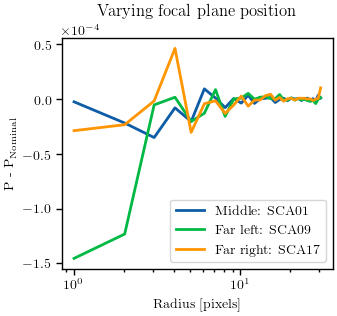

In [18]:
f, ax = plt.subplots(1, 1, figsize=(3.5, 3))
# ax.plot(r, flat_ps, label='flat')
# ax.plot(r, ps_no_subhalos, label='No subhalos')
ax.plot(r, dif_1, label='Middle: SCA01')
ax.plot(r, dif_9, label='Far left: SCA09')
ax.plot(r, dif_17, label='Far right: SCA17')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('Radius [pixels]')
ax.set_ylabel(r'P - P$_{\textrm{Nominal}}$')
ax.legend()
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.title('Varying focal plane position')
plt.savefig(os.path.join(figure_dir, 'ps_focal_plane_pos.png'))
plt.show()

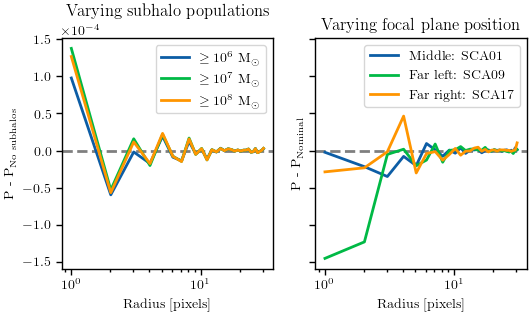

In [19]:
f, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

# ax.plot(r, flat_ps, label='flat')
# ax.plot(r, ps_no_subhalos, label='No subhalos')
ax[0].axhline(0, color='black', linestyle='--', alpha=0.5)
ax[0].plot(r, dif_6, label='$\geq 10^6$ M$_\odot$')
ax[0].plot(r, dif_7, label='$\geq 10^7$ M$_\odot$')
ax[0].plot(r, dif_8, label='$\geq 10^8$ M$_\odot$')
ax[0].set_xscale('log')
# ax.set_yscale('log')
ax[0].set_xlabel('Radius [pixels]')
ax[0].set_ylabel(r'P - P$_{\textrm{No subhalos}}$')
ax[0].legend()
ax[0].set_title('Varying subhalo populations')

ax[1].axhline(0, color='black', linestyle='--', alpha=0.5)
ax[1].plot(r, dif_1, label='Middle: SCA01')
ax[1].plot(r, dif_9, label='Far left: SCA09')
ax[1].plot(r, dif_17, label='Far right: SCA17')
ax[1].set_xscale('log')
# ax.set_yscale('log')
ax[1].set_xlabel('Radius [pixels]')
ax[1].set_ylabel(r'P - P$_{\textrm{Nominal}}$')
ax[1].legend()
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax[1].set_title('Varying focal plane position')

plt.savefig(os.path.join(figure_dir, 'ps_one_system.png'))
plt.show()